<h1> Oridnary Least Squares Regression </h1>

In this notebook we apply an OLS model to USD-UER exchange rate data.

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
from pylab import mpl, plt
import pandas_datareader as pdr
from sklearn.linear_model import LinearRegression

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
%matplotlib notebook

<h2> Data Preperation <
These are the parameters for our analysis. We define the start and end time of the data we want to download, and the variable train_test_divide is the datetime that seperates out training data (before this date) and testing data (after this date). The parameters for our OLS model will be the data from the two pervious days, indicated by setting lags to 2.

In [3]:
start = dt.datetime(2010, 1, 4)
train_test_divide = dt.datetime(2017, 6, 29)
end = dt.datetime(2018, 6, 29)
lags = 2

Here we load the data, calculate the returns, and also the direction (whether the returns are positive or negative on a given day).

In [4]:
data = pdr.data.DataReader('DEXUSEU', 'fred', start, end)
data.columns = ['EUR']
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data.returns).astype(int)
print(data.head())

               EUR   returns  direction
DATE                                   
2010-01-05  1.4402 -0.001180         -1
2010-01-06  1.4404  0.000139          1
2010-01-07  1.4314 -0.006268         -1
2010-01-08  1.4357  0.003000          1
2010-01-11  1.4536  0.012391          1


Generate the lag data.

In [5]:
cols = []

for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["returns"].shift(lag)
    cols.append(col)

data.dropna(inplace=True)
print(data.head())

               EUR   returns  direction     lag_1     lag_2
DATE                                                       
2010-01-07  1.4314 -0.006268         -1  0.000139 -0.001180
2010-01-08  1.4357  0.003000          1 -0.006268  0.000139
2010-01-11  1.4536  0.012391          1  0.003000 -0.006268
2010-01-12  1.4523 -0.000895         -1  0.012391  0.003000
2010-01-13  1.4492 -0.002137         -1 -0.000895  0.012391


Plotting the one and two day lags against each other shows no particular pattern.

<IPython.core.display.Javascript object>


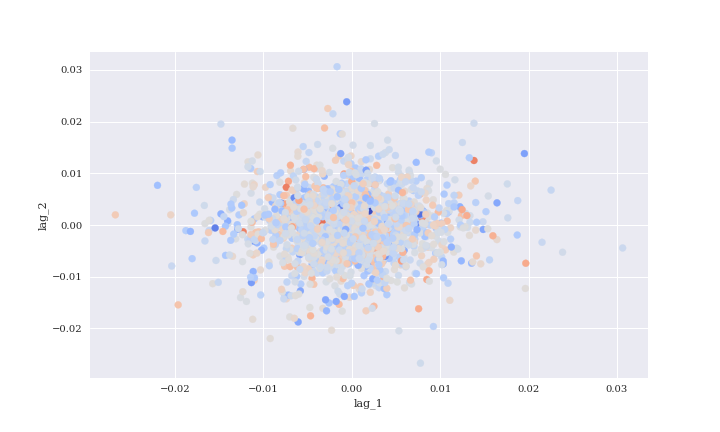

Text(0, 0.5, 'lag_2')

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x=data[cols[0]], y=data[cols[1]], c=data['returns'], cmap="coolwarm")
plt.xlabel(cols[0])
plt.ylabel(cols[1])

<h2> Regression </h2>

Here we divide our data into training and testing samples.

In [7]:
train = data.iloc[data.index < train_test_divide].copy()
test = data.iloc[data.index >= train_test_divide].copy()

We build one model to predict actual returns, and the other to predict the direction data.

In [8]:
returns_model = LinearRegression()
direction_model = LinearRegression()
returns_model.fit(train[cols], train['returns'])
direction_model.fit(train[cols], train['direction'])

LinearRegression()

Make prediction with each model. We make predictions on our training data as a sanity check, and on the test data to actually verify the model works.

In [9]:
train['pos_ols_1'] = returns_model.predict(train[cols])
train['pos_ols_2'] = direction_model.predict(train[cols])

test['pos_ols_1'] = returns_model.predict(test[cols])
test['pos_ols_2'] = direction_model.predict(test[cols])
test.head()

,EUR,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
DATE,,,,,,,
2017-06-29,1.1420,0.004916,1,0.005648,0.009246,-0.000087,-0.115698
2017-06-30,1.1411,-0.000788,-1,0.004916,0.005648,-0.000083,-0.083272
2017-07-03,1.1367,-0.003863,-1,-0.000788,0.004916,-0.000096,-0.043889
2017-07-06,1.1409,0.006419,1,-0.003863,-0.000788,-0.000094,0.018811
2017-07-07,1.1396,-0.001140,-1,0.006419,-0.003863,-0.000063,-0.017859


Turn the model output into direction data.

In [10]:
train[['pos_ols_1', 'pos_ols_2']] = train[['pos_ols_1', 'pos_ols_2']].apply(np.sign).astype(int)
test[['pos_ols_1', 'pos_ols_2']] = test[['pos_ols_1', 'pos_ols_2']].apply(np.sign).astype(int)
test.head()

In [12]:
train['returns_ols_1'] = train['pos_ols_1'] * train['returns']
train['returns_ols_2'] = train['pos_ols_2'] * train['returns']
test['returns_ols_1'] = test['pos_ols_1'] * test['returns']
test['returns_ols_2'] = test['pos_ols_2'] * test['returns']

Sum the returns for each model. On the training data both models outperform the long position, with ols_1 performing the best. But on the test data, both models are outperformed by simply holding the long position.

In [13]:
train[['returns', 'returns_ols_1', 'returns_ols_2']].sum().apply(np.exp)

returns          0.856758
returns_ols_1    1.163340
returns_ols_2    0.968303
dtype: float64

In [14]:
test[['returns', 'returns_ols_1', 'returns_ols_2']].sum().apply(np.exp)

returns          1.011443
returns_ols_1    0.988687
returns_ols_2    0.924183
dtype: float64

View the cumulative returns of our model on the train and test set.

<IPython.core.display.Javascript object>


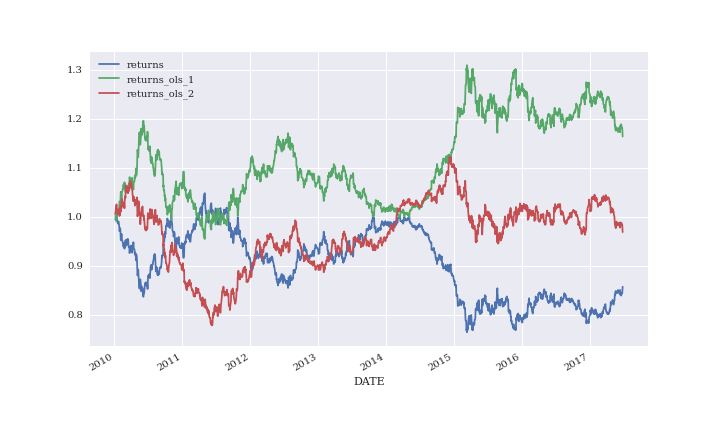

<AxesSubplot:xlabel='DATE'>

In [15]:
train[['returns', 'returns_ols_1', 'returns_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6))

<IPython.core.display.Javascript object>


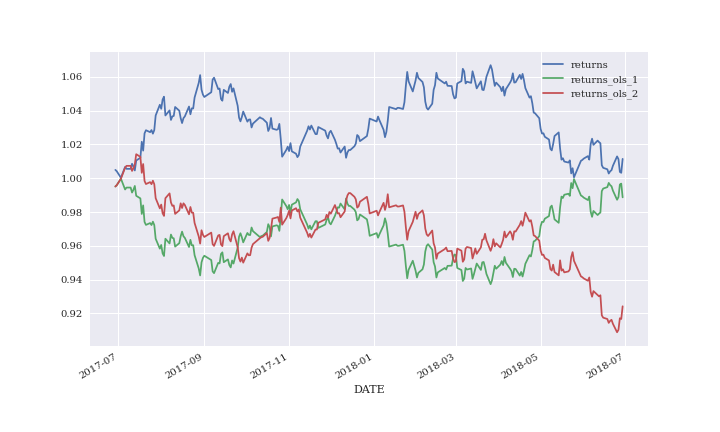

<AxesSubplot:xlabel='DATE'>

In [16]:
test[['returns', 'returns_ols_1', 'returns_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6))